<a href="https://colab.research.google.com/github/UEC-MaTa/News_Aggregator/blob/main/retry_News_Aggregator%EF%BC%88%E5%8F%82%E8%80%83%E3%80%80%E6%BC%94%E7%BF%92%EF%BC%9AStackOverflow_%E3%81%AE%E8%B3%AA%E5%95%8F%E3%81%AB%E5%AF%BE%E3%81%99%E3%82%8B%E3%83%9E%E3%83%AB%E3%83%81%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E%E3%80%81news_category_classification_multiclass_lstm_ipyn%E3%80%81%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# News Aggregator
（参考）演習：StackOverflow の質問に対するマルチクラス分類
ニュースのテキスト分類を応用してみる

In [70]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.utils.np_utils import to_categorical

In [71]:
print(tf.__version__)

2.12.0


In [72]:
# 下記セルを実行すると、authorization codeの入力を求められます。
# 出力されたリンク先をクリックし、Googleアカウントにログインし、
# authorization codeをコピーし、貼り付けをおこなってください。
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import os
import pandas as pd

#newsCorpora.csv
newsCorpora = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/newsCorpora.csv',sep='\t',  names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
display(newsCorpora.shape)
display(newsCorpora)

(422419, 8)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [74]:
#2pageSessions.csv
twopageSessions = pd.read_csv('/content/drive/MyDrive/Tensorflow/NewsAggregator/2pageSessions.csv',sep='\t',  names=['STORY', 'HOSTNAME', 'CATEGORY', 'URL'])
display(twopageSessions.shape)
display(twopageSessions)

(15516, 4)

,STORY,HOSTNAME,CATEGORY,URL
0,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ http://techcrunch.com/2...
1,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,techcrunch.com,b,http://techcrunch.com/ecommerce/ http://techcr...
2,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/2014/ http://www.bnn.ca...
3,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/news http://www.bnn.ca/News/...
4,dxyGGb4iN9Cs9aMZTKQpJeoiQfruM,www.bnn.ca,b,http://www.bnn.ca/News/News-Listing.aspx?Secto...
...,...,...,...,...
15511,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.upi.com,b,http://www.upi.com/ http://www.upi.com/Busines...
15512,dkPjabOt_3c58pM7cXTzwf0VDxtQM,www.webpronews.com,b,http://www.webpronews.com/ http://www.webprone...
15513,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel/traveller-tips...
15514,d3DTRVmvpPPpa8MG61j9MfjG4GkuM,www.smh.com.au,b,http://www.theage.com.au/travel http://www.smh...


In [75]:
newsCorpora.dtypes

ID            int64
TITLE        object
URL          object
PUBLISHER    object
CATEGORY     object
STORY        object
HOSTNAME     object
TIMESTAMP     int64
dtype: object

In [76]:
twopageSessions.dtypes

STORY       object
HOSTNAME    object
CATEGORY    object
URL         object
dtype: object

In [77]:
#creating a new dataset with only relevant features.
ds = newsCorpora[['TITLE','CATEGORY']]

print(ds.head()) #★

#shuffling rows with the help of sample, here (frac = 1) means return all rows
ds = ds.sample(frac=1).reset_index(drop=True)

print(ds.head())

                                               TITLE CATEGORY
0  Fed official says weak data caused by weather,...        b
1  Fed's Charles Plosser sees high bar for change...        b
2  US open: Stocks fall after Fed official hints ...        b
3  Fed risks falling 'behind the curve', Charles ...        b
4  Fed's Plosser: Nasty Weather Has Curbed Job Gr...        b
                                               TITLE CATEGORY
0  With $41.4 million, 'Captain America' holds of...        e
1  U.S. Existing Home Sales Drop To Lowest Level ...        b
2                    GE 2Q profit climbs 13 per cent        b
3  Boeing Finalizes Earlier $56 Billion 777X Orde...        b
4  Disney's 'Frozen' Becomes Number 1 Animated Fi...        e


drop=Falseは、あまり影響なし？

In [78]:
ds.shape

(422419, 2)

In [79]:
#checking for null values
ds.isnull().sum()

TITLE       0
CATEGORY    0
dtype: int64

In [80]:
#M class has way less data than the orthers, thus the classes are unbalanced.
ds.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

<Axes: xlabel='CATEGORY', ylabel='count'>

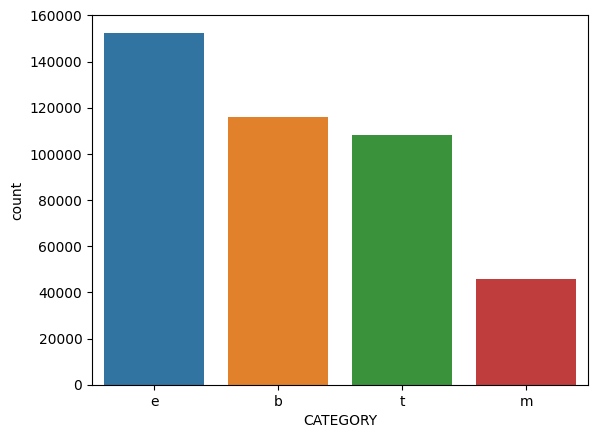

In [81]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = ds)

In [82]:
#I do aspire here to have balanced classes ★notebooke2c7d39000.ipynbより
num_of_categories = 45000 #★制限を戻す
#shuffled = data.reindex(np.random.permutation(data.index)) ★シャッフルは、上で実行済み
#https://docs.google.com/document/d/1yCGwcOrNaS-piPpez0hG_EKY4sqsNyRL4p7WQ_QQzy0/edit
shuffled = ds #★上でシャッフルしたdsをコピー
e = shuffled[shuffled['CATEGORY'] == 'e'] [:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'] [:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'] [:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'] [:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [83]:
concated #確認

,TITLE,CATEGORY,LABEL
82613,Toronto area gas prices predicted to jump to a...,b,0
145509,Schools partner for National Kick Butts Day,m,0
143870,Actress Kristin Cavallari doesn't want her bab...,m,0
159167,Eye Tests Show Potential To Detect Alzheimer's...,m,0
159001,Treatment in vein? Doses of blood from younger...,m,0
...,...,...,...
82413,Daimler Tests Self-Driving Truck in 2025 Targe...,b,0
11652,Listen As Jonah Hill Apologizes For Slur On Ho...,e,0
24392,“On The Run” Beyoncé And Jay Z Confirm Joint Tour,e,0
119758,T-Mobile's third act: A push to end industry o...,t,0


In [84]:
#M class has way less data than the orthers, thus the classes are unbalanced.
concated.CATEGORY.value_counts() #★確認

b    45000
m    45000
t    45000
e    45000
Name: CATEGORY, dtype: int64

In [85]:
#One-hot encode the lab ★notebooke2c7d39000.ipynbより
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
#print('★', concated) #★
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1) #★このif文の意味合いは分からず

print('★★', concated) #★
'''
 [1. 0. 0. 0.] e
 [0. 1. 0. 0.] b
 [0. 0. 1. 0.] t
 [0. 0. 0. 1.] m
'''

82613     1
145509    3
143870    3
159167    3
159001    3
122624    2
56242     1
54509     1
136033    3
120824    2
Name: LABEL, dtype: int64
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
★★                                                     TITLE CATEGORY  LABEL
82613   Toronto area gas prices predicted to jump to a...        b      1
145509        Schools partner for National Kick Butts Day        m      3
143870  Actress Kristin Cavallari doesn't want her bab...        m      3
159167  Eye Tests Show Potential To Detect Alzheimer's...        m      3
159001  Treatment in vein? Doses of blood from younger...        m      3
...                                                   ...      ...    ...
82413   Daimler Tests Self-Driving Truck in 2025 Targe...        b      1
11652   Listen As Jonah Hill Apologizes For Slur On Ho...        e      0
24392   “On The Run” Beyoncé And J

'\n [1. 0. 0. 0.] e\n [0. 1. 0. 0.] b\n [0. 0. 1. 0.] t\n [0. 0. 0. 1.] m\n'

In [86]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') #original was '<br />'
  #return tf.strings.regex_replace(stripped_html,
                                  #'[%s]' % re.escape(string.punctuation),
                                  #'')
  return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

★  
**tf.strings.regex_replace**  
正規表現 patternにマッチする inputの要素を rewriteで置き換える。

tf.strings.regex_replace(
    input, pattern, rewrite, replace_global=True, name=None
)  
tf.strings.regex_replace("Text with tags.<br /><b>contains html</b>",
                         "<[^>]+>", " ")  
<tf.Tensor: shape=(), dtype=string, numpy=b'Text with tags.  contains html '>  

Args  
**input**	string Tensor,処理するソース文字列。  
**pattern**	文字列またはスカラー文字列 Tensor,使用する正規表現、詳細は https://github.com/google/re2/wiki/Syntax を参照。  
**rewrite**	文字列またはスカラー文字列 Tensor、マッチ置換で使用する値は、バックスラッシュエスケープの数字(\ 1から\ 9)をサポートします。  
**replace_global**	bool, Trueの場合は重複しないすべてのマッチを置換し、それ以外の場合は最初のマッチのみを置換する。  
**name**	操作の名前(オプション)。

**Returns**  
inputと同形状の文字列 Tensorを指定置換した。

In [87]:
max_features = 8000
sequence_length = 130

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

**tf.keras.layers.TextVectorization**  https://runebook.dev/ja/docs/tensorflow/keras/layers/textvectorization  
TensorFlowの tf.keras.layers.TextVectorizationレイヤーは、文字列入力(テキストなど)のバッチを数値テンソルのバッチに変換する前処理レイヤーである。文字列を単語にトークン化し、語彙に基づいて各単語を整数にマッピングし、各文字列を整数のシーケンスとして符号化することでこれを実現する。この層は、感情分析や言語モデリングなどの自然言語処理タスクに有用である。

TextVectorizationレイヤーの主な特徴として、カスタムのトークン化と正規化のサポート、設定可能な語彙サイズと最大配列長、入力データに語彙を適応させる機能などがあります。さらに、他のKerasレイヤーと組み合わせて使用することで、幅広い自然言語処理タスクのためのカスタムモデルを構築することができます。

tf.keras.layers.TextVectorization(  
    max_tokens=None,  
    standardize='lower_and_strip_punctuation',  
    split='whitespace',  
    ngrams=None,  
    output_mode='int',  
    output_sequence_length=None,  
    pad_to_max_tokens=False,  
    vocabulary=None,  
    idf_weights=None,  
    sparse=False,  
    ragged=False,  
    **kwargs  
)  

**Args**  
**max_tokens**	このレイヤーのボキャブラリーの最大サイズ。これは、語彙を適合させるとき、または pad_to_max_tokens=Trueを設定するときにのみ指定する必要があります。なお、この語彙にはOOVトークンが1つ含まれているので、有効なトークン数は (max_tokens-1-(1 if output_mode =="int" else 0))です。  
**standardize**	入力テキストに適用する標準化のためのオプションの仕様。値として指定できる。  
None:標準化されていない。
"lower_and_strip_punctuation":テキストは小文字になり、句読点はすべて削除されます。
"lower":文字は小文字になります。
"strip_punctuation" :句読点はすべて削除されます。
呼び出し可能であること。入力は呼び出し可能な関数に渡され、標準化されて返されるはずです。  
**split**	入力テキストを分割するためのオプションの指定。値は以下の通り。
None:割れがない。
"whitespace":空白文字で分割される。
"character":ユニコード文字ごとに分割する。
呼び出し可能。標準化された入力は、呼び出し可能な関数に渡され、その関数は分割されて返される必要があります。  
**ngrams**	分割された入力テキストから作成するngramを指定するオプション。整数を渡すと、その整数までのngramが作成され、整数のタプルを渡すと、そのタプルで指定した値のngramが作成されます。Noneを渡すと、ngramは作成されない。  
**output_mode**	レイヤーの出力に関するオプションの指定。 "int", "multi_hot", "count", "tf_idf"のいずれかを指定し,以下のようにレイヤーを構成する。
"int":分割文字列トークン1個につき1個の整数インデックスを出力する。 output_mode =="int" の場合,0 はマスクされた位置のために予約される.これにより,ボキャブラリーのサイズは max_tokens-1 ではなく max_tokens-2 となる.
"multi_hot":バッチごとに、vocab_sizeまたはmax_tokensサイズのint配列を1つ出力し、そのインデックスにマップされたトークンがバッチアイテムに少なくとも1回は存在するすべての要素に1を含む。
"count": "multi_hot"と同様であるが、int配列にそのインデックスのトークンがバッチアイテムに出現した回数をカウントしている。
"tf_idf": "multi_hot"と同様ですが、TF-IDFアルゴリズムを適用して、各トークンスロットの値を求めます。 "int"出力では、任意の形状の入力と出力がサポートされる。その他の出力モードでは、現在、ランク1入力(分割後はランク2出力)のみがサポートされています。  
**output_sequence_length**	INTモードでのみ有効です。設定された場合、出力は時間次元が正確に output_sequence_lengthの値になるようにパディングまたは切り捨てられ、分割ステップの結果のトークンの数にかかわらず、 (batch_size,output_sequence_length)の形のテンソルになる。デフォルトはNoneです。  
**pad_to_max_tokens**	"multi_hot", "count", "tf_idf" モードでのみ有効です。Trueの場合、語彙のユニークトークンの数がmax_tokensより少なくても、出力はその特徴軸が max_tokensにパディングされ、語彙のサイズに関係なく (batch_size,max_tokens)の形のテンソルになる。デフォルトはFalseです。  
**vocabulary**	オプション。文字列の配列、またはテキストファイルへの文字列パスのどちらかを指定する。配列を渡す場合、文字列の語彙を含むタプル、リスト、1次元numpy配列、または1次元テンソルを渡すことができる。ファイルパスを渡す場合、ファイルには語彙の各用語につき1行が含まれる必要がある。この引数が設定されている場合、レイヤーを adapt()する必要はない。  
**idf_weights**	output_modeが "tf_idf"の場合のみ有効。語彙と同じ長さのタプル、リスト、1次元のnumpy配列、または1次元テンソル。 vocabularyが設定され、 output_modeが "tf_idf"の場合、この引数を与える必要がある。  
**ragged**	ブール値です。 "int"出力モードにのみ適用される。Trueの場合、文字列分割後に各シーケンスが異なる長さになる可能性がある、密な Tensorの代わりに RaggedTensorを返します。デフォルトはFalseです。  
**sparse**	ブール値です。 "multi_hot", "count", "tf_idf" 出力モードのみに適用可能です。Trueの場合、密集した Tensorの代わりに SparseTensorを返します。 デフォルトはFalseです。

In [88]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
  #expand_dimsメソッドを用いて、tensorflow2.0で生成したtensorの次元を増やす
  #https://www.tcom242242.net/entry/python-basic/tensorflow2/tensorflow2-0tensor-tf-expand_dims/

  #tf.expand_dimsを使用する場合は、拡張する元のTensorと拡張したい軸をaxis引数で指定します。例えば、先頭に追加したい場合には「axis=0」とします。
  #上記の例では、末尾に追加する例では「axis=-1」としています。もちろん上記の例で「axis=1」としても同様の結果が得られますが、
  #末尾に追加する場合には「axis=-1」で指定する場合も多いですので覚えておきましょう。
  #https://tech.nkhn37.net/tensorflow-tensor-expand-dims/

In [89]:
# Make a text-only dataset (without labels), then call adapt
train_text = concated["TITLE"] #★original was ds
vectorize_layer.adapt(train_text)
print(vectorize_layer(train_text).shape) #★

X = vectorize_text(train_text, labels)
print(X)

(180000, 130)
(<tf.Tensor: shape=(180000, 130), dtype=int64, numpy=
array([[6464,  887,  132, ...,    0,    0,    0],
       [2684, 2381,    6, ...,    0,    0,    0],
       [1371, 6676, 7623, ...,    0,    0,    0],
       ...,
       [   1,    4,    1, ...,    0,    0,    0],
       [6601,  696,  916, ...,    0,    0,    0],
       [  44, 1720,    1, ...,    0,    0,    0]])>, array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32))


上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [91]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print(" 3 ---> ",vectorize_layer.get_vocabulary()[3])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  september
 313 --->  house
 3 --->  in
Vocabulary size: 8000


In [97]:
print(train_text[82613])
print(X[0][0])

Toronto area gas prices predicted to jump to around $1.42 a litre on jitters over  ...
tf.Tensor(
[6464  887  132   91 5028    2  600    2  866 6583    9    1    7 5487
   26    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0], shape=(130,), dtype=int64)


In [96]:
# ★
for i in [6464, 887, 132, 91, 5028, 2, 600, 2, 866, 6583, 9, 1, 7, 5487, 26]:
  print(i, " ---> ",vectorize_layer.get_vocabulary()[i])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

6464  --->  toronto
887  --->  area
132  --->  gas
91  --->  prices
5028  --->  predicted
2  --->  to
600  --->  jump
2  --->  to
866  --->  around
6583  --->  142
9  --->  a
1  --->  [UNK]
7  --->  on
5487  --->  jitters
26  --->  over
Vocabulary size: 8000


In [23]:
#★Tensorflowでnumpyの挙動をさせる
#https://qiita.com/ppza53893/items/28e7f2c5261c8a2e404c
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#splitting the Dataset into Train and Test set
X_train,X_test,y_train,y_test=train_test_split(X[0], X[1], test_size=0.25,random_state=42)
print(X_train.shape,y_train.shape) #★
print(X_test.shape,y_test.shape) #★

(135000, 130) (135000, 4)
(45000, 130) (45000, 4)


モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [24]:
print(X_train, y_train)

tf.Tensor(
[[1108 3283 5691 ...    0    0    0]
 [2519    1  969 ...    0    0    0]
 [ 106  429  252 ...    0    0    0]
 ...
 [2772    1   11 ...    0    0    0]
 [ 452 2272   75 ...    0    0    0]
 [1803  362   11 ...    0    0    0]], shape=(135000, 130), dtype=int64) [[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [25]:
print(X_test, y_test)
#print(test_ds)

tf.Tensor(
[[ 968  301  179 ...    0    0    0]
 [3115 5684  569 ...    0    0    0]
 [1123 1036    1 ...    0    0    0]
 ...
 [  11  622 1416 ...    0    0    0]
 [  14 2424  339 ...    0    0    0]
 [   1 2867 1520 ...    0    0    0]], shape=(45000, 130), dtype=int64) [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


### モデルを作成する

ニューラルネットワークを作成します。

In [26]:
epochs = 10
emb_dim = 128
batch_size = 256

In [27]:
# max_features, sequence_lengthがaccuracyに影響を与えている 10000=>8000, 250=>130に変更
print('max_features = ', max_features, 'sequence_length = ', sequence_length)

max_features =  8000 sequence_length =  130


In [28]:
print(X_train) #★
print(y_train) #★
print(X_train[0]) #★
print(y_train[0]) #★

tf.Tensor(
[[1108 3283 5691 ...    0    0    0]
 [2519    1  969 ...    0    0    0]
 [ 106  429  252 ...    0    0    0]
 ...
 [2772    1   11 ...    0    0    0]
 [ 452 2272   75 ...    0    0    0]
 [1803  362   11 ...    0    0    0]], shape=(135000, 130), dtype=int64)
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
tf.Tensor(
[1108 3283 5691   10  373 1059   17 1687 1781  165   50    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

In [29]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping

In [30]:
model = Sequential()
model.add(Embedding(max_features, emb_dim, input_length=sequence_length))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax')) #★
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 130, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 130, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
422/422 [==============================] - 482s 1s/step - loss: 1.3872 - acc: 0.2496 - val_loss:

In [31]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1407/1407 [==============================] - 54s 38ms/step - loss: 1.3863 - acc: 0.2487
Test set
  Loss: 1.386
  Accuracy: 0.249


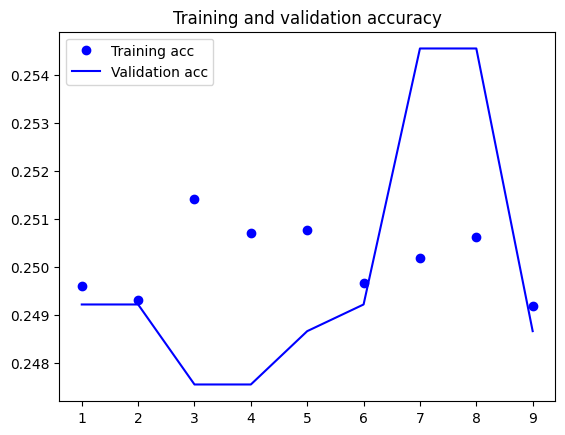

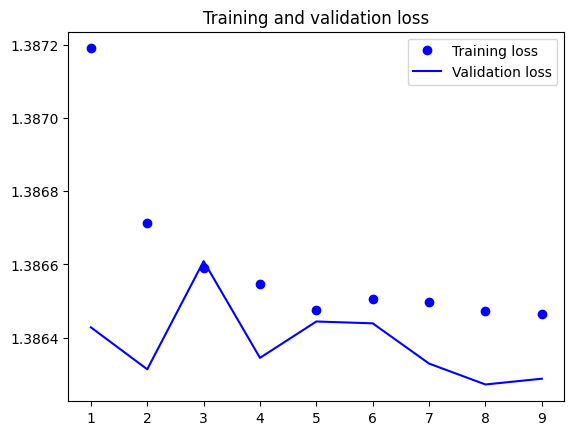

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
def vectorize_text_2(text):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text)

In [101]:
from keras.preprocessing.text import Tokenizer

In [130]:
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = vectorize_layer(txt)
print(seq)
pred = model.predict(seq)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

# ★
print(txt)
i=0
while seq[0][i] !=0:
  print(i, " ---> ",vectorize_layer.get_vocabulary()[seq[0][i]])
  i +=1

tf.Tensor(
[[3863  708  254 1332  247    2 4433  409    3  212    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]], shape=(1, 130), dtype=int64)
1/1 [==============================] - 0s 38ms/step
[[0.24894318 0.25115913 0.25195906 0.24793854]] science/tech
['Regular fast food eating linked to fertility issues in women']
0  --->  regular
1  --->  fast
2  --->  food
3  --->  eating
4  --->  linked
5  --->  to
6  --->  fertility
7

確認：   
1 Fed official says weak data caused by weather, should not slow taper http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss Los Angeles Times **b**

99457 Rio 2' is king of the jungle http://bostonherald.com/entertainment/movies/movie_reviews/2014/04/rio_2_is_king_of_the_jungle Boston Herald **e**

309370 BMW, Ford, Chrysler join Japanese automakers in airbag recall http://kitchener.ctvnews.ca/bmw-ford-chrysler-join-japanese-automakers-in-airbag-recall-1.1882231 CTV News **t**

422937 Phoenix boy undergoes surgery to repair throat damage - CBS 3 Springfield ... http://www.cbs3springfield.com/story/26368078/phoenix-boy-undergoes-surgery-to-repair-throat-damage-from-button-battery WSHM-TV **m**


In [129]:
txt = ["Fed official says weak data caused by weather, should not slow taper"] #確認
seq = vectorize_layer(txt)
seq = seq.numpy()
print(seq)
pred = model.predict(seq)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

# ★
print(txt)
i=0
while seq[0][i] !=0:
  print(i, " ---> ",vectorize_layer.get_vocabulary()[seq[0][i]])
  i +=1

[[ 234  523   24 1023   76 1770   18  964  223   35 1174 7895    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
1/1 [==============================] - 0s 34ms/step
[[0.24894318 0.25115913 0.25195906 0.24793854]] science/tech
['Fed official says weak data caused by weather, should not slow taper']
0  --->  fed
1  --->  official
2  --->  says
3  --->  weak
4  --->  data
5  --->  caused
6  --->  by
7  --->  weather
8  --->  should
9  ---> 

In [54]:
txt = ["Rio 2' is king of the jungle"] #確認
seq = vectorize_layer(txt)
print(seq)
pred = model.predict(seq)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 130), dtype=int64)
1/1 [==============================] - 0s 61ms/step
[[0.24894318 0.25115913 0.25195906 0.24793854]] science/tech


In [55]:
txt = ["BMW, Ford, Chrysler join Japanese automakers in airbag recall"] #確認
seq = vectorize_layer(txt)
print(seq)
pred = model.predict(seq)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

tf.Tensor(
[[1 1 1 1 1 1 7 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 130), dtype=int64)
1/1 [==============================] - 0s 37ms/step
[[0.24894318 0.25115913 0.25195906 0.24793854]] science/tech


In [56]:
txt = ["Phoenix boy undergoes surgery to repair throat damage"] #確認
seq = vectorize_layer(txt)
print(seq)
pred = model.predict(seq)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

tf.Tensor(
[[1 1 1 1 3 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 130), dtype=int64)
1/1 [==============================] - 0s 345ms/step
[[0.24894318 0.25115913 0.25195906 0.24793854]] science/tech
